In [4]:
#!pip install scikit-learn

In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob


from matplotlib import cm

### Part 1: Extract license plate from sample image

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [4]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

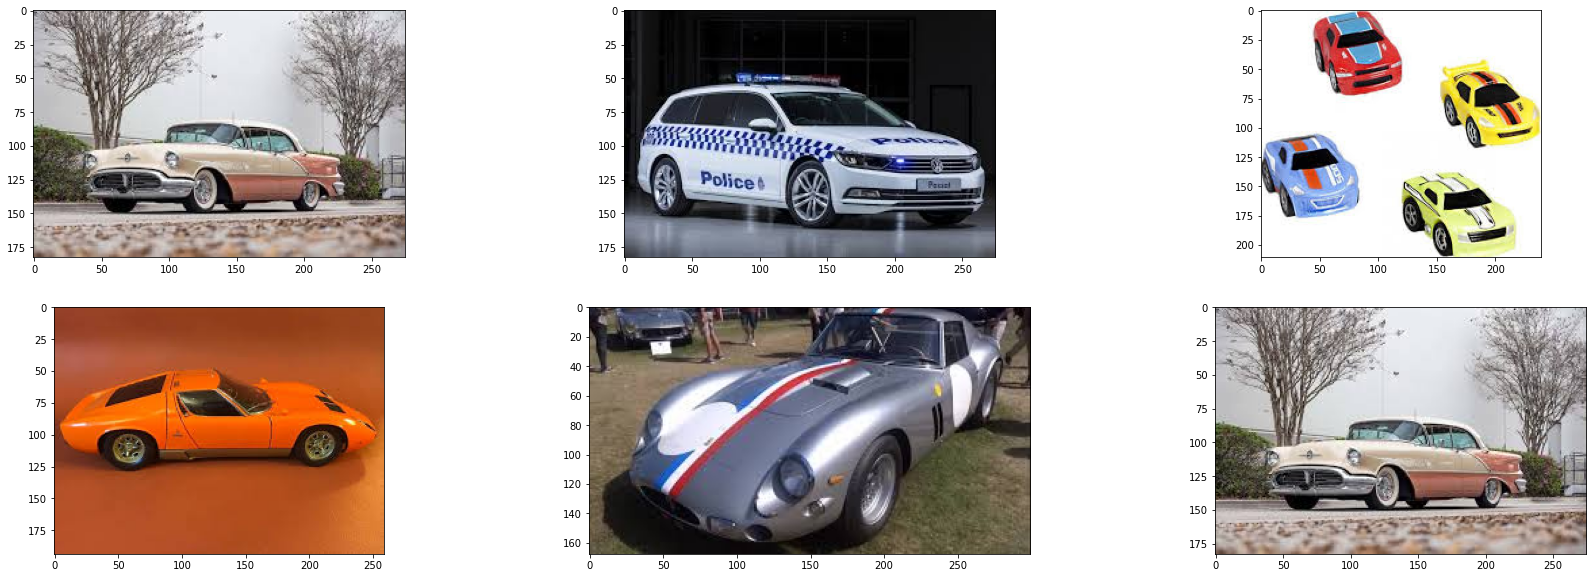

In [5]:
#image_paths = glob.glob("../../TSK_00_MSC/wt2-body-tracker/det_car_originals/0_0_696.jpg")
allimagepaths = glob.glob('figures/*.jpeg')

all_images = []

for impath in allimagepaths:
    img = cv2.imread(impath)
    all_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    
plt.figure(num=1, figsize = (30,10))
rows = 2
cols = 3

for i in range(0, rows*cols):
    plt.subplot(rows,cols, i+1)
    plt.imshow(all_images[i])

color_img = all_images[0]

plt.imshow(color_img)

194 259
194 259
[58, 77]
(194, 259, 3)
[[0.0, 0.0, 0.0], [0.996078431372549, 0.36470588235294116, 0.011764705882352941], [0.9254901960784314, 0.32941176470588235, 0.0], [0.6666666666666666, 0.2901960784313726, 0.10196078431372549], [0.6705882352941176, 0.29411764705882354, 0.10588235294117647]]
0.0, 0.0, 0.0
0.996078431372549, 0.36470588235294116, 0.011764705882352941
0.9254901960784314, 0.32941176470588235, 0.0
0.6666666666666666, 0.2901960784313726, 0.10196078431372549
0.6705882352941176, 0.29411764705882354, 0.10588235294117647


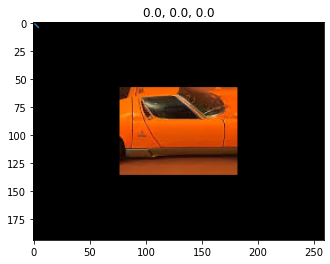

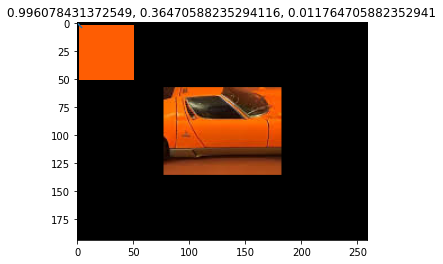

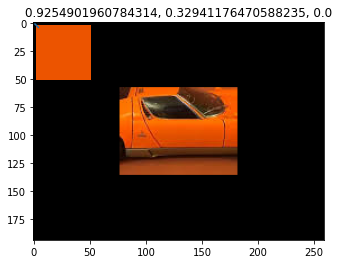

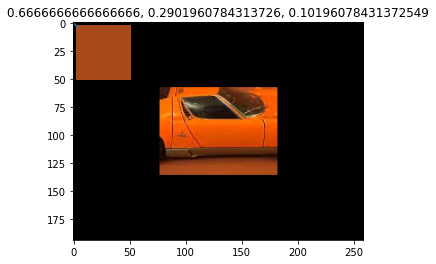

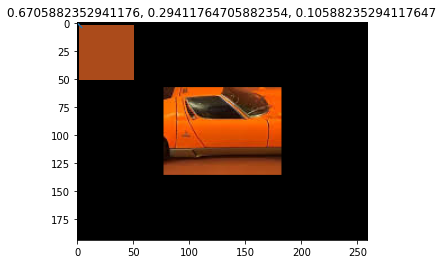

In [57]:
from PIL import Image
from matplotlib import cm
import matplotlib.patches as patches

def set_mask(per, img):
# create a mask
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    print(img.shape[0], img.shape[1])
    print(mask.shape[0], mask.shape[1])
   
    hor_per = int(img.shape[0] *per /100)
    ver_per = int(img.shape[1] *per / 100)
    print([hor_per, ver_per])
    #mask[100:300, 100:400] = 255
    mask[hor_per : img.shape[0]-hor_per, ver_per: img.shape[1] -ver_per] = 255
    masked_img = cv2.bitwise_and(img, img,mask = mask)
    
    return masked_img 

def find_dominant_color(img):
        #Resizing parameters
        #width, height = 150,150
        #image = Image.open(filename)
        #image = image.resize((width, height),resample = 0)
        #Get colors from image object
        print(img.shape)
        #input_size = 224
        #cmimg = cm.gist_earth(img)*255
        #uintcm = cmimg.astype(np.uint8)
        #uintcm.resize((input_size, input_size,3))
        #print(uintcm.shape)        
        #img = Image.fromarray(uintcm)    
        
        img = Image.fromarray((img * 255).astype(np.uint8))
        width = 224
        height = 224
        #img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((input_size, input_size)).convert('RGB'))
        pixels = img.getcolors(width * height)
        #Sort them by count number(first element of tuple)
        sorted_pixels = sorted(pixels, key=lambda t: t[0])
        #Get the most frequent color
        dominant_color = []
        for cnt in range(1,6):
            dominant_color.append (np.array(sorted_pixels[-cnt][1]).tolist())
            
        norm_dominant_color = []
        
        for dlist in dominant_color:
            dd = []
            for c in dlist:
                dd.append(c/255)
            norm_dominant_color.append(dd)
        return norm_dominant_color
    
    
def plot_color_rects(img, dc):
    fig, ax = plt.subplots()

    ax.plot([1,4],[1,4])
    ax.imshow(img)
    ax.add_patch(patches.Rectangle(
        (1, 1),
        50,
        50,
        edgecolor = 'black',
        #facecolor = ()#'red',
        facecolor = (dc[0],dc[1], dc[2]),#'red',
        fill=True
     ) )
    title = str(dc).strip('[]')
    print(title)
    plt.title(str(title))
    #ax.title(str(dc))
    
for fignum, color_img in enumerate(all_images[3:4]):
    
    per = 30
    color_img = set_mask(per, color_img)
    norm_color_img = color_img/255
    #print(norm_color_img)
    dominant_color = find_dominant_color(norm_color_img)
    print(dominant_color)
    
    for dc in dominant_color:
        plot_color_rects(norm_color_img, dc)
    
    

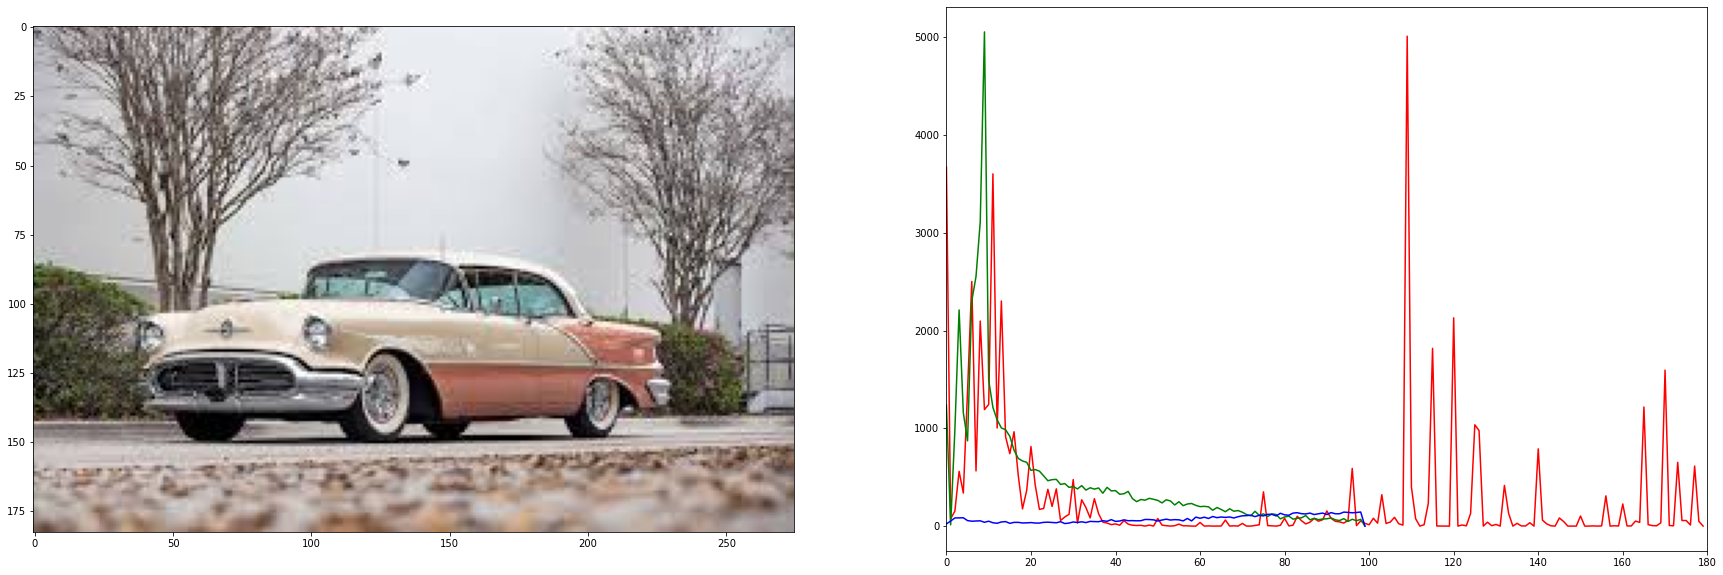

109


IndexError: index 109 is out of bounds for axis 0 with size 100

In [27]:
def plt_hist(fignum, color_img):
    hsv_color_img = cv2.cvtColor(color_img,cv2.COLOR_RGB2HSV)
    color = ('r','g','b')
    plt.figure(num = fignum, figsize = (30,10))
    plt.subplot(121)
    plt.imshow(color_img)
    plt.subplot(122)
    
    hist_h = cv2.calcHist([hsv_color_img],[0],None,[180],[0,179])
    plt.plot(hist_h,color = 'r')
    plt.xlim([0,180])
    
    hist_s = cv2.calcHist([hsv_color_img],[1],None,[100],[0,99])
    plt.plot(hist_s,color = 'g')
    plt.xlim([0,180])
    
    hist_v = cv2.calcHist([hsv_color_img],[2],None,[100],[0,99])
    plt.plot(hist_v,color = 'b')
    plt.xlim([0,180])
    
    
    plt.show()
    
    mi = np.argmax(hist_h)
    print(mi)
    print([hist_s[mi], hist_v[mi]])
    print(max(hist_s))
    print(max(hist_v))
    
    
for fignum, color_img in enumerate(all_images[0:1]):
    
    plt_hist(fignum, color_img)

In [39]:
def calc_hsv_hist_mask(img, mask, mask_flag):
    #img = cv.imread('home.jpg')
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    #hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    if mask_flag == True:
        hist = cv2.calcHist([hsv],[0],mask,[180],[0,180])
    else:
        hist = cv2.calcHist([hsv],[0],None,[180],[0,180])        
    
    
    pixelcnt = hsv.shape[0]*hsv.shape[1]
    print([hsv.shape, pixelcnt])
    
    hist = hist/pixelcnt
    return hist


def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)


def set_mask(per, img):
# create a mask
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    print(img.shape[0], img.shape[1])
    print(mask.shape[0], mask.shape[1])
   
    hor_per = int(img.shape[0] *per /100)
    ver_per = int(img.shape[1] *per / 100)
    print([hor_per, ver_per])
    #mask[100:300, 100:400] = 255
    mask[hor_per : img.shape[0]-hor_per, ver_per: img.shape[1] -ver_per] = 255
    masked_img = cv2.bitwise_and(img, img,mask = mask)
    
    return mask 

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plt_hist(data):    

    cm = plt.cm.RdBu_r

    n, bins, patches = plt.hist(data, 25, normed=1, color='green')
    for i, p in enumerate(patches):
        plt.setp(p, 'facecolor', cm(i/25)) # notice the i/25

    plt.show()

AttributeError: 'Rectangle' object has no property 'normed'

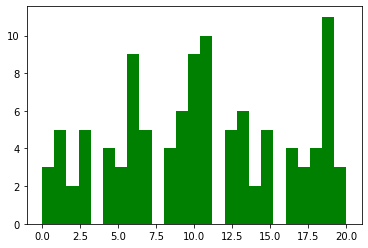

In [57]:
# Data in numpy array
data = np.array([12, 15, 13, 20, 19, 20, 11, 19, 11, 12, 19, 13, 
                        12, 10, 6, 19, 3, 1, 1, 0, 4, 4, 6, 5, 3, 7, 
                        12, 7, 9, 8, 12, 11, 11, 18, 19, 18, 19, 3, 6, 
                        5, 6, 9, 11, 10, 14, 14, 16, 17, 17, 19, 0, 2, 
                        0, 3, 1, 4, 6, 6, 8, 7, 7, 6, 7, 11, 11, 10, 
                        11, 10, 13, 13, 15, 18, 20, 19, 1, 10, 8, 16, 
                        19, 19, 17, 16, 11, 1, 10, 13, 15, 3, 8, 6, 9, 
                        10, 15, 19, 2, 4, 5, 6, 9, 11, 10, 9, 10, 9, 
                        15, 16, 18, 13])
    
for fignum, color_img in enumerate(all_images):
    plt_hist(data)

## Part 2: Segementing license characters

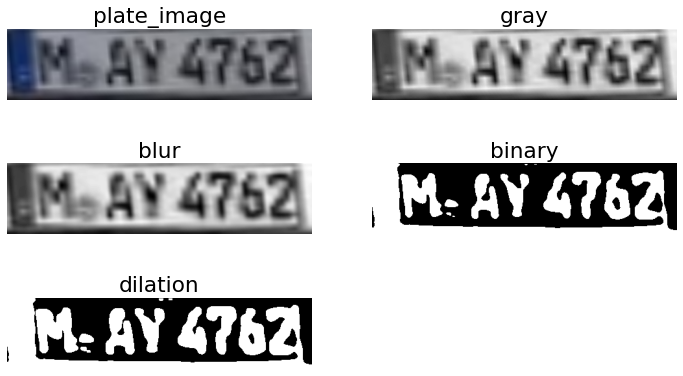

In [5]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

Detect 6 letters...


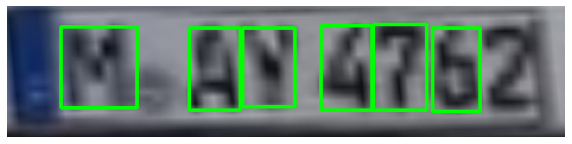

In [6]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

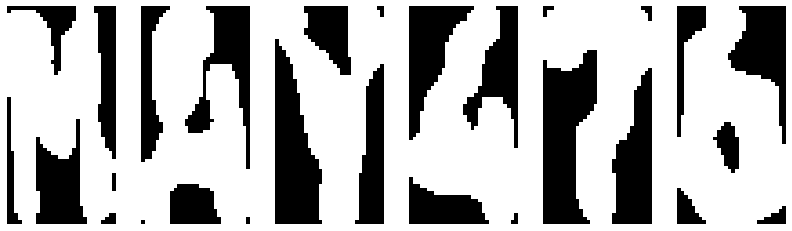

In [7]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

## Load pre-trained MobileNets model and predict

In [8]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [9]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

MAV476


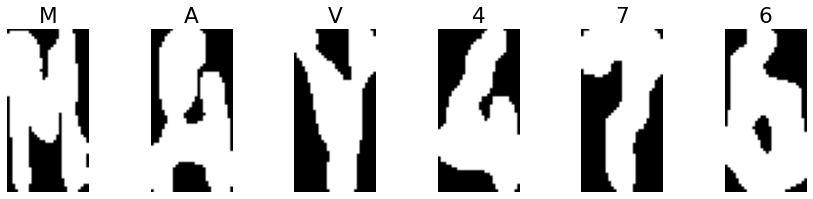

In [10]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
#plt.savefig('final_result.png', dpi=300)

# The end!